# Import required libraries

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pytorch_metric_learning.losses import TripletMarginLoss, ContrastiveLoss

## Triplet loss

The Triplet Loss encourages the distance between an anchor and a positive example to be smaller than the distance between the anchor and a negative example by at least a margin \( \alpha \).

$$
\mathcal{L}(A, P, N) = \max\left( \|f(A) - f(P)\|_2^2 - \|f(A) - f(N)\|_2^2 + \alpha, \; 0 \right)
$$

Where:

- \( A \): Anchor
- \( P \): Positive (same class)
- \( N \): Negative (different class)
- \( f(\cdot) \): Embedding function (e.g., neural network output)
- \( \alpha \): Margin (a positive constant)


In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
trainset = datasets.MNIST('../test', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

In [86]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute squared L2 distances
        pos_dist = F.pairwise_distance(anchor, positive, p=2)
        neg_dist = F.pairwise_distance(anchor, negative, p=2)

        # Triplet loss
        loss = F.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()


In [87]:
# Dummy embeddings (batch_size=4, embedding_dim=128)
anchor = torch.randn(4, 128, requires_grad=True)
positive = torch.randn(4, 128, requires_grad=True)
negative = torch.randn(4, 128, requires_grad=True)

criterion = TripletLoss(margin=1.0)
loss = criterion(anchor, positive, negative)

print("Triplet loss:", loss.item())
loss.backward()


Triplet loss: 0.2057662010192871


## Quadruplet Losses

The Quadruplet Loss improves upon Triplet Loss by adding a second negative sample and an additional constraint to enhance embedding separation.

$$
\mathcal{L}(A, P, N_1, N_2) = \max\left( \|f(A) - f(P)\|_2^2 - \|f(A) - f(N_1)\|_2^2 + \alpha, \; 0 \right) + \max\left( \|f(P) - f(N_2)\|_2^2 - \|f(N_1) - f(N_2)\|_2^2 + \beta, \; 0 \right)
$$

Where:

- \( A \): Anchor
- \( P \): Positive (same class)
- \( N_1 \): First Negative
- \( N_2 \): Second Negative (different class and ideally farther apart)
- \( f(\cdot) \): Embedding function (e.g., a neural network)
- \( \alpha \), \( \beta \): Margin hyperparameters


In [88]:
class QuadrupletLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=0.5):
        super(QuadrupletLoss, self).__init__()
        self.alpha = alpha  # Margin for anchor-positive-negative
        self.beta = beta    # Margin for positive-second negative

    def forward(self, anchor, positive, negative1, negative2):
        # L2 pairwise distances
        d_ap = F.pairwise_distance(anchor, positive, p=2)
        d_an = F.pairwise_distance(anchor, negative1, p=2)
        d_pn2 = F.pairwise_distance(positive, negative2, p=2)
        d_n1n2 = F.pairwise_distance(negative1, negative2, p=2)

        # First triplet term
        loss1 = F.relu(d_ap - d_an + self.alpha)

        # Second additional term
        loss2 = F.relu(d_pn2 - d_n1n2 + self.beta)

        # Combine both
        return (loss1 + loss2).mean()


## SphereFace

In [89]:
class SphereFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, m=4, scale=30.0):
        super(SphereFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.m = m
        self.scale = scale
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, labels):
        x_norm = F.normalize(input, dim=1)
        w_norm = F.normalize(self.weight, dim=1)
        cos_theta = F.linear(x_norm, w_norm)

        # Clamp to avoid NaNs
        cos_theta = cos_theta.clamp(-1 + 1e-7, 1 - 1e-7)
        theta = torch.acos(cos_theta)

        # SphereFace margin
        k = (self.m * theta / math.pi).floor()
        phi_theta = torch.cos(self.m * theta)
        phi_theta = ((-1.0) ** k) * phi_theta - 2 * k

        one_hot = torch.zeros_like(cos_theta)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        output = (one_hot * phi_theta) + ((1.0 - one_hot) * cos_theta)
        output *= self.scale
        return output



In [90]:
class SimpleCNN(nn.Module):
    def __init__(self, embedding_dim=2):  # For 2D visualization
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(64, embedding_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [91]:
model = SimpleCNN(embedding_dim=128).to(device)
criterion = SphereFaceLoss(in_features=128, out_features=10).to(device)

# Improved optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Store embeddings for plotting
all_feats = []
all_labels = []

for epoch in range(20):
    model.train()
    total_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        features = model(images)
        logits = criterion(features, labels)
        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()
    avg_loss = total_loss / len(trainloader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.8f}")

    # Save embeddings for plotting
    model.eval()
    with torch.no_grad():
        sample_data = next(iter(trainloader))
        imgs, lbls = sample_data[0].to(device), sample_data[1]
        feats = model(imgs).cpu()
        all_feats.append(feats)
        all_labels.append(lbls)


Epoch 1, Loss: 57.80087865
Epoch 2, Loss: 27.67410744
Epoch 3, Loss: 20.85737399
Epoch 4, Loss: 18.16917658
Epoch 5, Loss: 16.52081012
Epoch 6, Loss: 15.42495755
Epoch 7, Loss: 14.49809537
Epoch 8, Loss: 13.78445114
Epoch 9, Loss: 13.19362069
Epoch 10, Loss: 12.69372153
Epoch 11, Loss: 12.34176051
Epoch 12, Loss: 11.94486563
Epoch 13, Loss: 11.54320347
Epoch 14, Loss: 11.34587280
Epoch 15, Loss: 11.09257629
Epoch 16, Loss: 10.88513856
Epoch 17, Loss: 10.72652053
Epoch 18, Loss: 10.59940107
Epoch 19, Loss: 10.52292824
Epoch 20, Loss: 10.47286224


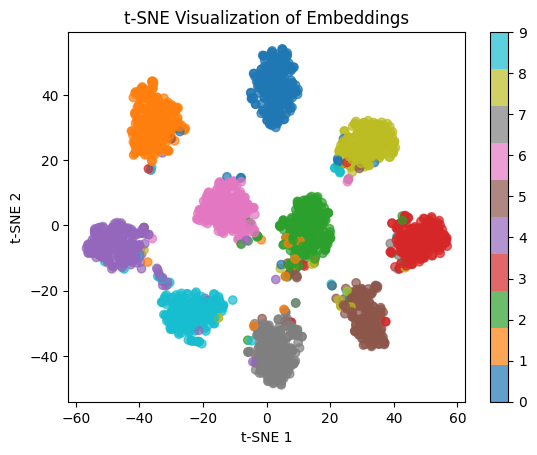

In [92]:
from sklearn.manifold import TSNE
feats = torch.cat(all_feats, dim=0)
labels = torch.cat(all_labels, dim=0)

reduced = TSNE(n_components=2, random_state=42).fit_transform(feats)
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="tab10", alpha=0.7)
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar()
plt.show()

## CosFace

The CosFace loss modifies the softmax function by introducing an additive margin to the cosine similarity:

**Formula:**

$$
\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \log \frac{e^{s (\cos(\theta_{y_i}) - m)}}{e^{s (\cos(\theta_{y_i}) - m)} + \sum_{j \ne y_i} e^{s \cos(\theta_j)}}
$$

Where:

- \( \theta_j \): angle between input and class \( j \)'s weight vector
- \( m \): additive cosine margin
- \( s \): scaling factor
- \( y_i \): ground truth class
- \( N \): batch size

This encourages greater separation between classes in angular space by enforcing a margin between the correct and incorrect logits.

---

In [93]:
class CosFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, margin=0.35, scale=30.0):
        super(CosFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.margin = margin
        self.scale = scale
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, labels):
        # Normalize feature vectors and weights
        input_norm = F.normalize(input, dim=1)
        weight_norm = F.normalize(self.weight, dim=1)

        # Cosine similarity
        cosine = F.linear(input_norm, weight_norm)

        # Add margin to correct class
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        output = cosine - one_hot * self.margin
        output *= self.scale
        return output


In [94]:
model = SimpleCNN(embedding_dim=128).to(device)
criterion = CosFaceLoss(in_features=128, out_features=10, margin=0.35, scale=30.0).to(device)

# Updated optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# For visualization
all_feats = []
all_labels = []

for epoch in range(40):
    model.train()
    total_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        embeddings = model(images)
        logits = criterion(embeddings, labels)
        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(trainloader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")
    scheduler.step()

    # Save features for plotting
    if epoch in [0, 4, 9, 19]:
        model.eval()
        with torch.no_grad():
            sample_imgs, sample_labels = next(iter(trainloader))
            sample_feats = model(sample_imgs.to(device)).cpu()
            all_feats.append(sample_feats)
            all_labels.append(sample_labels)


Epoch 1, Loss: 7.1582
Epoch 2, Loss: 2.0985
Epoch 3, Loss: 1.5400
Epoch 4, Loss: 1.3009
Epoch 5, Loss: 1.1430
Epoch 6, Loss: 1.0522
Epoch 7, Loss: 0.9751
Epoch 8, Loss: 0.9093
Epoch 9, Loss: 0.8357
Epoch 10, Loss: 0.7871
Epoch 11, Loss: 0.7485
Epoch 12, Loss: 0.7092
Epoch 13, Loss: 0.6716
Epoch 14, Loss: 0.6516
Epoch 15, Loss: 0.6189
Epoch 16, Loss: 0.6007
Epoch 17, Loss: 0.5810
Epoch 18, Loss: 0.5634
Epoch 19, Loss: 0.5535
Epoch 20, Loss: 0.5460
Epoch 21, Loss: 0.5441
Epoch 22, Loss: 0.5450
Epoch 23, Loss: 0.5506
Epoch 24, Loss: 0.5579
Epoch 25, Loss: 0.5681
Epoch 26, Loss: 0.5862
Epoch 27, Loss: 0.5937
Epoch 28, Loss: 0.5972
Epoch 29, Loss: 0.6076
Epoch 30, Loss: 0.6167
Epoch 31, Loss: 0.6146
Epoch 32, Loss: 0.6181
Epoch 33, Loss: 0.6291
Epoch 34, Loss: 0.6194
Epoch 35, Loss: 0.6217
Epoch 36, Loss: 0.6094
Epoch 37, Loss: 0.5949
Epoch 38, Loss: 0.5804
Epoch 39, Loss: 0.5730
Epoch 40, Loss: 0.5709


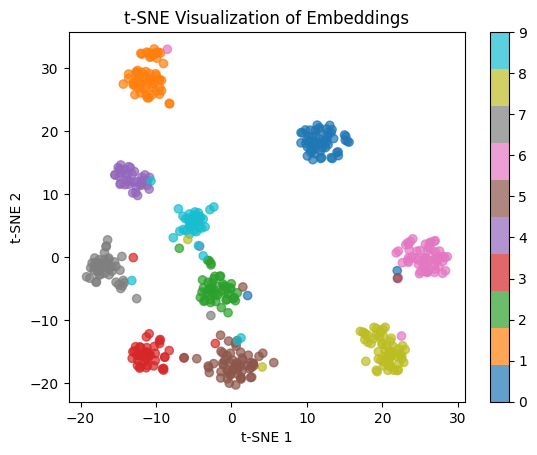

In [95]:
from sklearn.manifold import TSNE
feats = torch.cat(all_feats, dim=0)
labels = torch.cat(all_labels, dim=0)

reduced = TSNE(n_components=2, random_state=42).fit_transform(feats)
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="tab10", alpha=0.7)
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar()
plt.show()

## ArcFace

The ArcFace loss introduces an **additive angular margin** \( m \) to the angle \( \theta \) between feature and class weight vectors.

### **Formula:**

$$
\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \log \frac{e^{s \cdot \cos(\theta_{y_i} + m)}}{e^{s \cdot \cos(\theta_{y_i} + m)} + \sum_{j \ne y_i} e^{s \cdot \cos(\theta_j)}}
$$

Where:
- \( \cos(\theta_j) \) is the cosine similarity
- \( m \) is the angular margin (e.g., 0.5)
- \( s \) is a scaling factor (e.g., 30)
- \( N \) is the batch size
- \( y_i \) is the ground-truth class

ArcFace improves inter-class separability and intra-class compactness in angular space.

---


In [96]:
class ArcFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, margin=0.5, scale=30.0):
        super(ArcFaceLoss, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.margin = margin
        self.scale = scale
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin

    def forward(self, input, labels):
        input_norm = F.normalize(input, dim=1)
        weight_norm = F.normalize(self.weight, dim=1)
        cosine = F.linear(input_norm, weight_norm)
        sine = torch.sqrt(1.0 - torch.clamp(cosine**2, 0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m  # cos(θ + m)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale
        return output


In [97]:
model = SimpleCNN(embedding_dim=128).to(device)
criterion = ArcFaceLoss(in_features=128, out_features=10, margin=0.5, scale=30.0).to(device)

# Updated optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

all_feats = []
all_labels = []

for epoch in range(20):
    model.train()
    total_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        embeddings = model(images)
        logits = criterion(embeddings, labels)
        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(trainloader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")
    scheduler.step()

    if epoch in [0, 4, 9, 19]:
        model.eval()
        with torch.no_grad():
            sample_imgs, sample_labels = next(iter(trainloader))
            sample_feats = model(sample_imgs.to(device)).cpu()
            all_feats.append(sample_feats)
            all_labels.append(sample_labels)


Epoch 1, Loss: 8.6847
Epoch 2, Loss: 3.0958
Epoch 3, Loss: 2.3664
Epoch 4, Loss: 2.0048
Epoch 5, Loss: 1.7413
Epoch 6, Loss: 1.5838
Epoch 7, Loss: 1.4318
Epoch 8, Loss: 1.3712
Epoch 9, Loss: 1.2434
Epoch 10, Loss: 1.1939
Epoch 11, Loss: 1.1217
Epoch 12, Loss: 1.0757
Epoch 13, Loss: 1.0151
Epoch 14, Loss: 0.9730
Epoch 15, Loss: 0.9394
Epoch 16, Loss: 0.9047
Epoch 17, Loss: 0.8764
Epoch 18, Loss: 0.8601
Epoch 19, Loss: 0.8411
Epoch 20, Loss: 0.8307


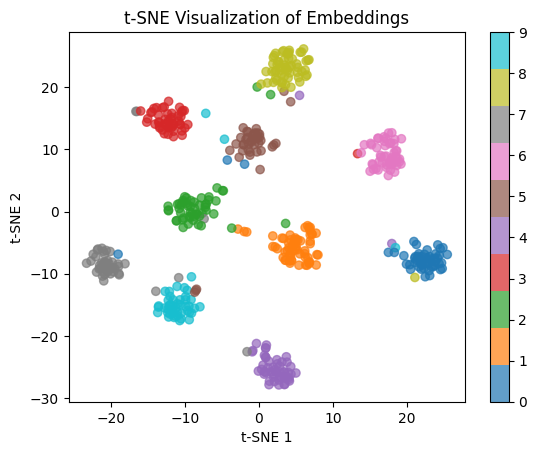

In [98]:
from sklearn.manifold import TSNE
feats = torch.cat(all_feats, dim=0)
labels = torch.cat(all_labels, dim=0)

reduced = TSNE(n_components=2, random_state=42).fit_transform(feats)
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="tab10", alpha=0.7)
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar()
plt.show()

## Histogram Loss

Histogram Loss is a deep metric learning loss function designed to minimize the probability that **a randomly chosen negative pair is more similar than a randomly chosen positive pair**.

### **Formula (Conceptual)**

The loss minimizes:

$$
\mathcal{L} = \sum_{t=1}^{T} h^{-}(t) \cdot \left( \sum_{k=t}^{T} h^{+}(k) \right)
$$

Where:
- \( h^+(t) \): histogram bin for positive pair similarity at bin \( t \)
- \( h^-(t) \): histogram bin for negative pair similarity at bin \( t \)
- \( T \): number of bins

### 🔍 Goal

Encourages all positive pairs to have higher similarity scores than negative pairs by minimizing their overlap in the similarity histogram.

---

### 🔧 Pros
- Does not require margin tuning like contrastive/triplet loss
- Uses **all positive and negative pairs** within a batch
- Differentiable histogram approximation

In [99]:
class HistogramLoss(nn.Module):
    def __init__(self, num_bins=100):
        super(HistogramLoss, self).__init__()
        self.num_bins = num_bins
        self.eps = 1e-7
        self.delta = 2.0 / (num_bins - 1)
        self.bins = torch.linspace(-1.0, 1.0, steps=num_bins)

    def forward(self, embeddings, labels):
        device = embeddings.device
        self.bins = self.bins.to(device)
        sim_matrix = F.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=2)
        label_matrix = labels.unsqueeze(1) == labels.unsqueeze(0)

        pos_mask = label_matrix & ~torch.eye(labels.size(0), device=device).bool()
        neg_mask = ~label_matrix

        pos_sims = sim_matrix[pos_mask]
        neg_sims = sim_matrix[neg_mask]

        pos_hist = self._compute_histogram(pos_sims)
        neg_hist = self._compute_histogram(neg_sims)

        loss = torch.sum(neg_hist * torch.cumsum(pos_hist, dim=0))
        return loss

    def _compute_histogram(self, sims):
        sims = sims.clamp(-1, 1)
        device = sims.device
        bins = self.bins.to(device)
        bin_width = self.delta

        # For each similarity, calculate soft assignments to bins using triangular kernel
        # hist[b] = sum over sims of max(0, 1 - |sim - bin_center|/bin_width)
        diff = torch.abs(sims.unsqueeze(1) - bins.unsqueeze(0)) / bin_width
        weights = torch.clamp(1 - diff, min=0)  # triangular kernel weights

        hist = weights.sum(dim=0)
        hist /= (sims.size(0) + self.eps)  # normalize histogram

        return hist



In [100]:
class SimpleCNN(nn.Module):
    def __init__(self, embedding_dim=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
        self.embedding = nn.Linear(64, embedding_dim)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.embedding(x)


In [101]:
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

model = SimpleCNN(128).to(device)
criterion = HistogramLoss()

# Optimizer with weight decay for regularization
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Cosine annealing scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=20)

# Data storage for visualization (optional)
all_feats = []
all_labels = []

for epoch in range(10):
    model.train()
    epoch_loss = 0

    for x, y in trainloader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        embeddings = model(x)
        # Normalize embeddings for metric learning
        embeddings = F.normalize(embeddings, p=2, dim=1)

        loss = criterion(embeddings, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()  # Adjust learning rate

    avg_loss = epoch_loss / len(trainloader)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.6f}")

    # Save sample embeddings for visualization at selected epochs
    if epoch in [0, 4, 9, 19]:
        model.eval()
        with torch.no_grad():
            # Random batch sample for embedding analysis
            sample_imgs, sample_labels = next(iter(trainloader))
            sample_imgs = sample_imgs.to(device, non_blocking=True)
            sample_feats = model(sample_imgs)
            sample_feats = F.normalize(sample_feats, p=2, dim=1).cpu()

            all_feats.append(sample_feats)
            all_labels.append(sample_labels)


Epoch 1, Avg Loss: 0.158361
Epoch 2, Avg Loss: 0.051147
Epoch 3, Avg Loss: 0.034485
Epoch 4, Avg Loss: 0.026599
Epoch 5, Avg Loss: 0.022090
Epoch 6, Avg Loss: 0.019358
Epoch 7, Avg Loss: 0.017465
Epoch 8, Avg Loss: 0.015870
Epoch 9, Avg Loss: 0.014474
Epoch 10, Avg Loss: 0.013625


https://github.com/deepinsight/insightface.git


In [102]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Reduce feature dimensions with t-SNE
feats = torch.cat(all_feats, dim=0)
labels = torch.cat(all_labels, dim=0)
reduced = TSNE(n_components=2, random_state=42).fit_transform(feats)

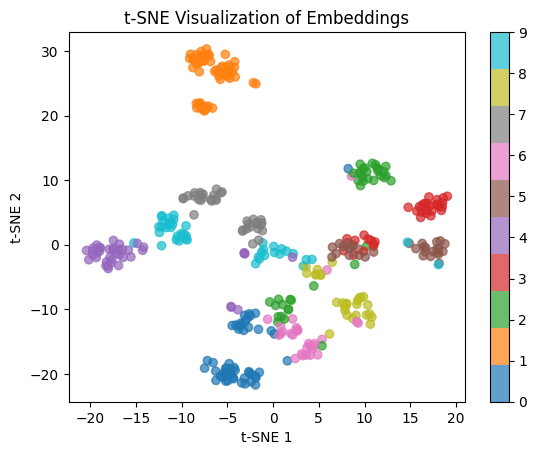

In [103]:

plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="tab10", alpha=0.7)
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar()
plt.show()


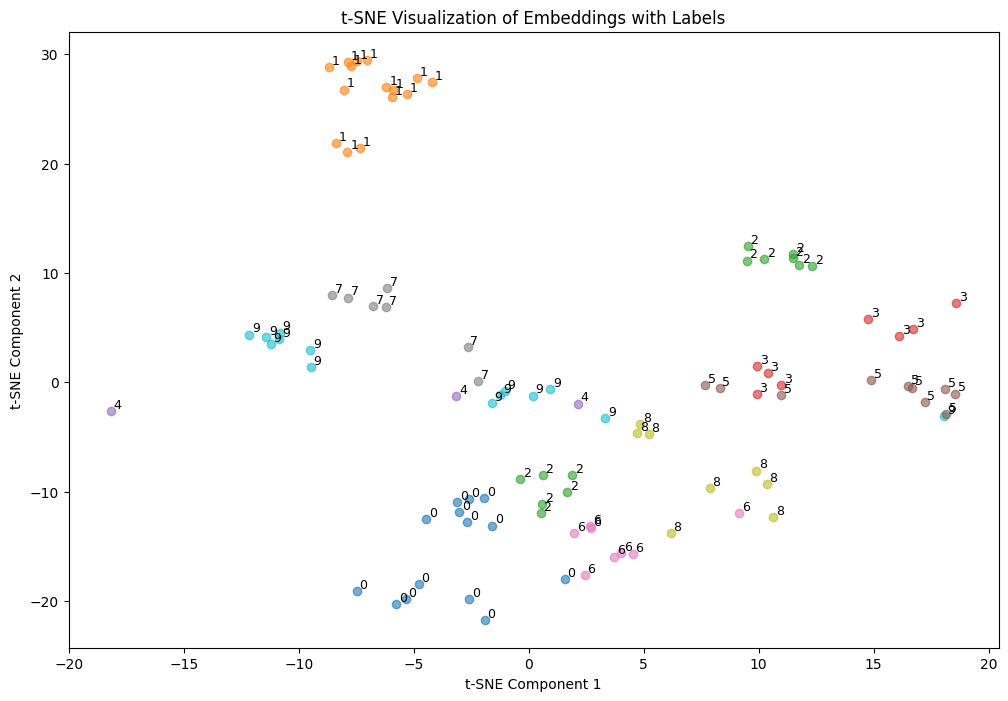

In [104]:
# Sample a subset of points for better visualization 
indices = np.random.choice(len(reduced), size=100, replace=False)  # Reduced to 100 for clearer labels
reduced_sample = reduced[indices]
labels_sample = labels[indices]

# Create scatter plot with labels
plt.figure(figsize=(12, 8))
for i in range(len(reduced_sample)):
    x, y = reduced_sample[i]
    label = str(labels_sample[i].item())
    plt.scatter(x, y, c=[plt.cm.tab10(int(label) / 10)], alpha=0.6)
    plt.annotate(label, (x, y), xytext=(2, 2), textcoords='offset points',
                 fontsize=9, color='black')

plt.title("t-SNE Visualization of Embeddings with Labels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

This code:
1. Samples fewer points (100) to avoid overcrowding of labels
2. Uses plt.annotate() to add text labels next to each point
3. Each point shows its corresponding digit (0-9)
4. Colors are consistent with the original colormap
